# Ritz method for a beam

**November, 2018**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

In [2]:
%matplotlib notebook
init_printing()

# Graphics setup
gray = '#757575'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["text.color"] = gray
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.color"] = gray
plt.rcParams["ytick.color"] = gray
plt.rcParams["axes.labelcolor"] = gray
plt.rcParams["axes.edgecolor"] = gray
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = 4, 3

In [3]:
x = symbols('x')
M, EI, f, L = symbols("M EI f L")
psi_exact = -(2*M + f*L**2)/(2*EI)*x + f*L*x**2/(2*EI) - f*x**3/(6*EI)
w_exact = (2*M + f*L**2)/(4*EI)*x**2 - f*L/(6*EI)*x**3 + f/(24*EI)*x**4
lamda_exact = f*(L - x)

In [4]:
def plot_expr(expr, x, rango=(0, 1), ax=None, linestyle="solid"):
    """Plot SymPy expressions of a single variable"""
    expr_num = lambdify(x, expr, "numpy")
    x0 = rango[0]
    x1 = rango[1]
    x_num = np.linspace(0, 1, 101)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.plot(x_num, expr_num(x_num), linestyle=linestyle)

## Lagrange multiplier formulation

We can write the problem as minimizing the functional

$$J(\psi, w) = \int\limits_0^L\left[\frac{EI}{2}\left(\frac{\mathrm{d}^2 w}{\mathrm{d}x^2}\right)^2 -
f w\right]\mathrm{d}x + M\psi(L)\, ,$$

subject to

$$G(\psi, w) \equiv \psi + \frac{\mathrm{d}w}{\mathrm{d}x} = 0\, .$$

The Lagrangian is given by

$$L(\psi, w, \lambda) = \int\limits_0^L\left[\frac{EI}{2}\left(\frac{\mathrm{d}^2 w}{\mathrm{d}x^2}\right)^2 -
f w\right]\mathrm{d}x + \int\limits_0^L \lambda\left(\psi + \frac{\mathrm{d}x}{\mathrm{d}x}\right)\mathrm{d}x + M\psi(L)\, , $$

where $\lambda$ is the Lagrange multiplier, which in this case represents the shear force.

In [5]:
def lagran(x, psi, w, lamda, M, EI, f, L):
    F = EI/2*diff(psi, x)**2 - f*w
    G = lamda*(psi + diff(w, x))
    L = integrate(F, (x, 0, L)) + integrate(G, (x, 0, L)) + M*psi.subs(x, L)
    return L
    

In [6]:
def ritz_multiplier(x, M, EI, f, L, nterms):
    a = symbols("a0:%i"%(nterms))
    b = symbols("b0:%i"%(nterms))
    c = symbols("c0:%i"%(nterms))
    var = a + b + c
    psi = sum(a[k]*x**(k + 1) for k in range(nterms))
    w = sum(b[k]*x**(k + 1) for k in range(nterms))
    lamda = sum(c[k]*x**k for k in range(nterms))
    M, EI, f, L = symbols("M EI f L")
    L = lagran(x, psi, w, lamda, M, EI, f, L)
    eqs = [L.diff(C) for C in var]
    sol = solve(eqs, var)
    return w.subs(sol), psi.subs(sol), lamda.subs(sol)

<IPython.core.display.Javascript object>


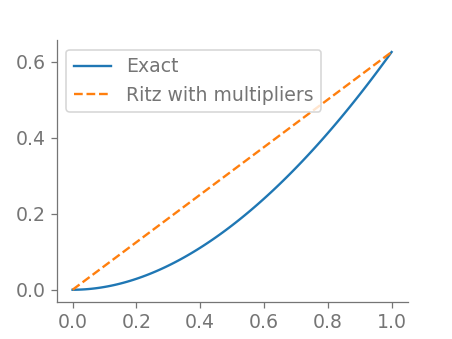

<IPython.core.display.Javascript object>


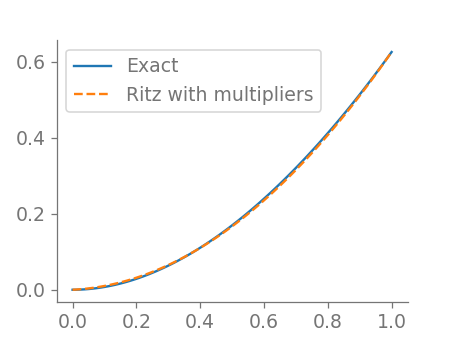

<IPython.core.display.Javascript object>


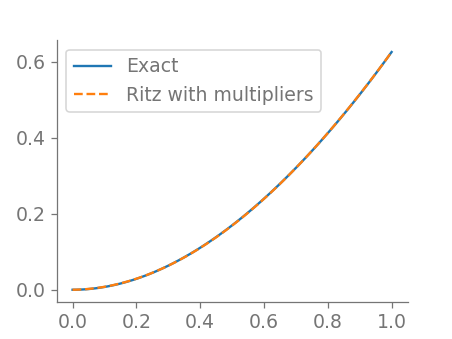

In [7]:
subs = {L: 1, EI:1, M:1, f: 1}
errors_mult = []
for nterms in range(1, 4):
    w, psi, lamda = ritz_multiplier(x, M, EI, f, L, nterms)
    err = (integrate((w - w_exact)**2, (x, 0, L)) +
           integrate((psi - psi_exact)**2, (x, 0, L)) +
           integrate((lamda - lamda_exact)**2, (x, 0, L)))
    norm = (integrate(w_exact**2, (x, 0, L)) +
           integrate(psi_exact**2, (x, 0, L)) +
           integrate(lamda_exact**2, (x, 0, L)))
    errors_mult.append(N(sqrt((err/norm).subs(subs))))
    plt.figure()
    ax = plt.gca()
    plot_expr(w_exact.subs(subs), x, ax=ax)
    plot_expr(w.subs(subs), x, ax=ax, linestyle="dashed")
    plt.legend(["Exact", "Ritz with multipliers"]);
    
    

In [8]:
errors_mult

# The penalty function formulation

The augmented functional for this formulation is given by

$$P_K (\psi, w) = J(\psi, w) + \frac{K}{2}\int\limits_0^L \left(\psi + \frac{\mathrm{d}w}{\mathrm{d}x}\right)^2\mathrm{d}x\, ,$$

where $K$ is the penalty parameter.


In [9]:
def augmented(x, psi, w, K, M, EI, f, L):
    F = EI/2*diff(psi, x)**2 - f*w
    G = (psi + diff(w, x))
    P = integrate(F, (x, 0, L)) + K/2*integrate(G**2, (x, 0, L)) + M*psi.subs(x, L)
    return P

In [10]:
def ritz_penalty(x, K, M, EI, f, L, nterms):
    a = symbols("a0:%i"%(nterms))
    b = symbols("b0:%i"%(nterms))
    var = a + b
    w = sum(a[k]*x**(k + 1) for k in range(nterms))
    psi = sum(b[k]*x**(k + 1) for k in range(nterms))
    M, EI, f, L = symbols("M EI f L")
    P = augmented(x, psi, w, K, M, EI, f, L)
    eqs = [P.diff(C) for C in var]
    sol = solve(eqs, var)
    return w.subs(sol), psi.subs(sol)

<IPython.core.display.Javascript object>


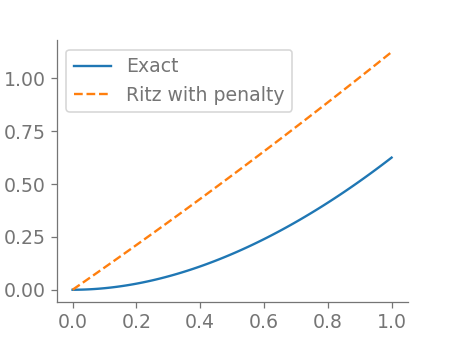

<IPython.core.display.Javascript object>


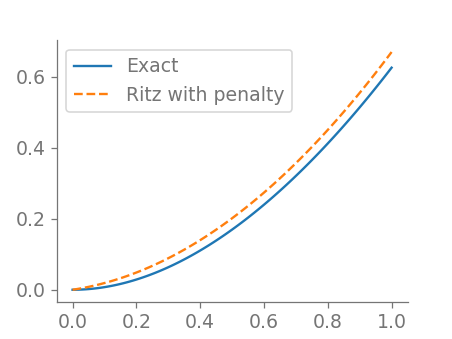

<IPython.core.display.Javascript object>


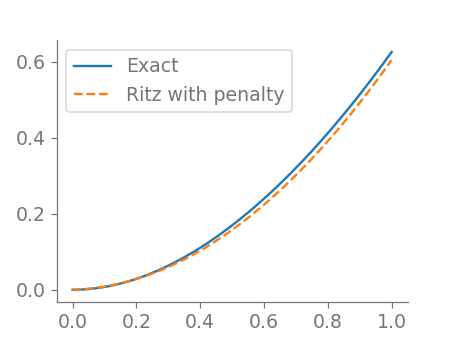

In [11]:
K = symbols("K")
errors_penalty = []
for K_val in [1, 10, 100]:
    subs = {L: 1, EI:1, M:1, f: 1, K: K_val}
    w, psi = ritz_penalty(x, K, M, EI, f, L, 2)
    err = (integrate((w - w_exact)**2, (x, 0, L)) +
           integrate((psi - psi_exact)**2, (x, 0, L)) +
           integrate((lamda - lamda_exact)**2, (x, 0, L)))
    norm = (integrate(w_exact**2, (x, 0, L)) +
           integrate(psi_exact**2, (x, 0, L)) +
           integrate(lamda_exact**2, (x, 0, L)))
    errors_penalty.append(N(sqrt((err/norm).subs(subs))))
    plt.figure()
    ax = plt.gca()
    plot_expr(w_exact.subs(subs), x, ax=ax)
    plot_expr(w.subs(subs), x, ax=ax, linestyle="dashed")
    plt.legend(["Exact", "Ritz with penalty"]);

In [12]:
errors_penalty